In [1]:
from IPython.display import Image, display
from IPython.display import HTML
from IPython.display import display, Markdown

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import pandas as pd
import prettytable

In [3]:
## Mount Drive into Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Deep active learning with diversity sampling**

In this experiment, we try to see if and how diversity sampling strategy reduces the calibration error of machine learning models. We further compare the performance of diversity sampling to uncertainty sampling and random sampling. We use the scikit-learn's MLP model with the optimal parameters we found via hyperparameter search.


In [27]:
x = PrettyTable()
column_names = ["Dataset", "Train/val/test", "Classes", "Number of active learning batches", "Batch Size", "Size of initial training data"]
x.add_column(column_names[0], ['Gop Sentiment', 'Disaster Relevance', 'Economic news article tone and relevance','Chems Contributing to Disease','Corporate messaging', 'Sentiment Self-driving Cars', 'Drug relation'])
x.add_column(column_names[1], ["6195/576/628", "7557/740/684", "5098/452/526","3088/186/162","2615/120/117", "5399/150/147", "1866/75/72"])
x.add_column(column_names[2], [2, 2, 2, 2, 3, 3, 3])
x.add_column(column_names[3], ["10","10","10","10","10","10","10"])
x.add_column(column_names[4], ["600", "740", "500", "300", "255", "530", "180"])
x.add_column(column_names[5], ["195", "157", "98", "88", "66", "99", "66"])
print(x)

+------------------------------------------+----------------+---------+-----------------------------------+------------+-------------------------------+
|                 Dataset                  | Train/val/test | Classes | Number of active learning batches | Batch Size | Size of initial training data |
+------------------------------------------+----------------+---------+-----------------------------------+------------+-------------------------------+
|              Gop Sentiment               |  6195/576/628  |    2    |                 10                |    600     |              195              |
|            Disaster Relevance            |  7557/740/684  |    2    |                 10                |    740     |              157              |
| Economic news article tone and relevance |  5098/452/526  |    2    |                 10                |    500     |               98              |
|      Chems Contributing to Disease       |  3088/186/162  |    2    |           

In [19]:
def printSelectedItems(eval_outliers, data):
    print("Sampled items in the first batch:")
    sampled_items = []
    outliers = str(eval_outliers).split()
    for outlier in outliers:
        outlier_id = int(outlier)
        outlier_text = data.loc[data['itemID'] == outlier_id].text.values
        if len(outlier_text) != 0 and outlier_text[0] not in sampled_items:
            sampled_items.append(outlier_text[0])

    for item in sampled_items:
        print("\n", item)

def printPrettyTable(title, column_names, datasetName, eval, test):
    x = PrettyTable()
    x.title = title
    x.add_column(column_names[0], [datasetName, '', '', '', '', '', '', '', '', ''])
    x.add_column(column_names[1], test['alBatch'] )
    x.add_column(column_names[2], eval[' f1_val'])
    x.add_column(column_names[3], eval[' ece_val'])
    x.add_column(column_names[4], test[' f1_val'])
    x.add_column(column_names[5], test[' ece_val'])
    print(x)

def plot_performance(data, title, legendLoc):
    fig, ax = plt.subplots(nrows = 3, ncols=3, figsize=(35, 15))
    fig.suptitle(title)

    for i in range(3):
        y_f1 = []
        y_ece = []
        y_brier = []
        for el in data[i][1]:
          y_f1.append(el[0])
          y_ece.append(el[1])
          y_brier.append(el[2])

        for y_arr, label in zip(y_f1, data[i][4]):
            ax[i][0].plot(data[i][0], y_arr, label=label)

        for y_arr, label in zip(y_ece, data[i][4]):
            ax[i][1].plot(data[i][0], y_arr, label=label)

        for y_arr, label in zip(y_brier, data[i][4]):
            ax[i][2].plot(data[i][0], y_arr, label=label)
    
        ax[i][0].set_title('F1 Scores on ' + data[i][5] + ' set')
        ax[i][0].set_xlabel(data[i][2])
        ax[i][0].set_ylabel(data[i][3])
        ax[i][0].legend(loc=legendLoc, prop={'size': 8})
        ax[i][0].set_ylim([0, 1])
        ax[i][1].set_title('ECE Scores on ' + data[i][5] + ' set')
        ax[i][1].set_xlabel(data[i][2])
        ax[i][1].set_ylabel(data[i][3])
        ax[i][1].legend(loc='upper left', prop={'size': 8})
        ax[i][1].set_ylim([0, 1])
        ax[i][2].set_title('Brier Scores on ' + data[i][5] + ' set')
        ax[i][2].set_xlabel(data[i][2])
        ax[i][2].set_ylabel(data[i][3])
        ax[i][2].legend(loc='upper left', prop={'size': 8})
        ax[i][2].set_ylim([0, 1])
    plt.show()

# ***Gop Sentiment Dataset***

In [9]:
#read data and results

res_path = 'drive/My Drive/Colab Notebooks/deepALForCalibration/res/'
data_folder = 'drive/My Drive/Colab Notebooks/deepALForCalibration/datasets/binary/gop_sentiment/'

oneSideSelectionData = data_folder + '1_train_indexed_gop_sentiment_binary_resampledByOneSideSelection.csv'
random_oneSideSelection = res_path + 'random_1-gop_sentiment-MLP3_resampledByOneSideSelection.csv'
uncertainty_oneSideSelection = res_path + 'uncertainty_1-gop_sentiment-MLP3_resampledByOneSideSelection.csv'
diversity_oneSideSelection = res_path + 'diversity_1-gop_sentiment-MLP3_resampledByOneSideSelection.csv'

randomUndersamplingData = data_folder + '1_train_indexed_gop_sentiment_binary_resampledByRandomUndersampling.csv'
random_undersampling = res_path + 'random_1-gop_sentiment-MLP3_resampledByRandomUndersampling.csv'
uncertainty_undersampling = res_path + 'uncertainty_1-gop_sentiment-MLP3_resampledByRandomUndersampling.csv'
diversity_undersampling = res_path + 'diversity_1-gop_sentiment-MLP3_resampledByRandomUndersampling.csv'

data_oneSideSelection = pd.read_csv(oneSideSelectionData)
random_res_oneSideSelection = pd.read_csv(random_oneSideSelection)
uncertainty_res_oneSideSelection = pd.read_csv(uncertainty_oneSideSelection)
diversity_res_oneSideSelection = pd.read_csv(diversity_oneSideSelection)

data_randomUndersampling = pd.read_csv(randomUndersamplingData)
random_res_randomUndersampling = pd.read_csv(random_undersampling)
uncertainty_res_randomUndersampling = pd.read_csv(uncertainty_undersampling)
diversity_res_randomUndersampling = pd.read_csv(diversity_undersampling)

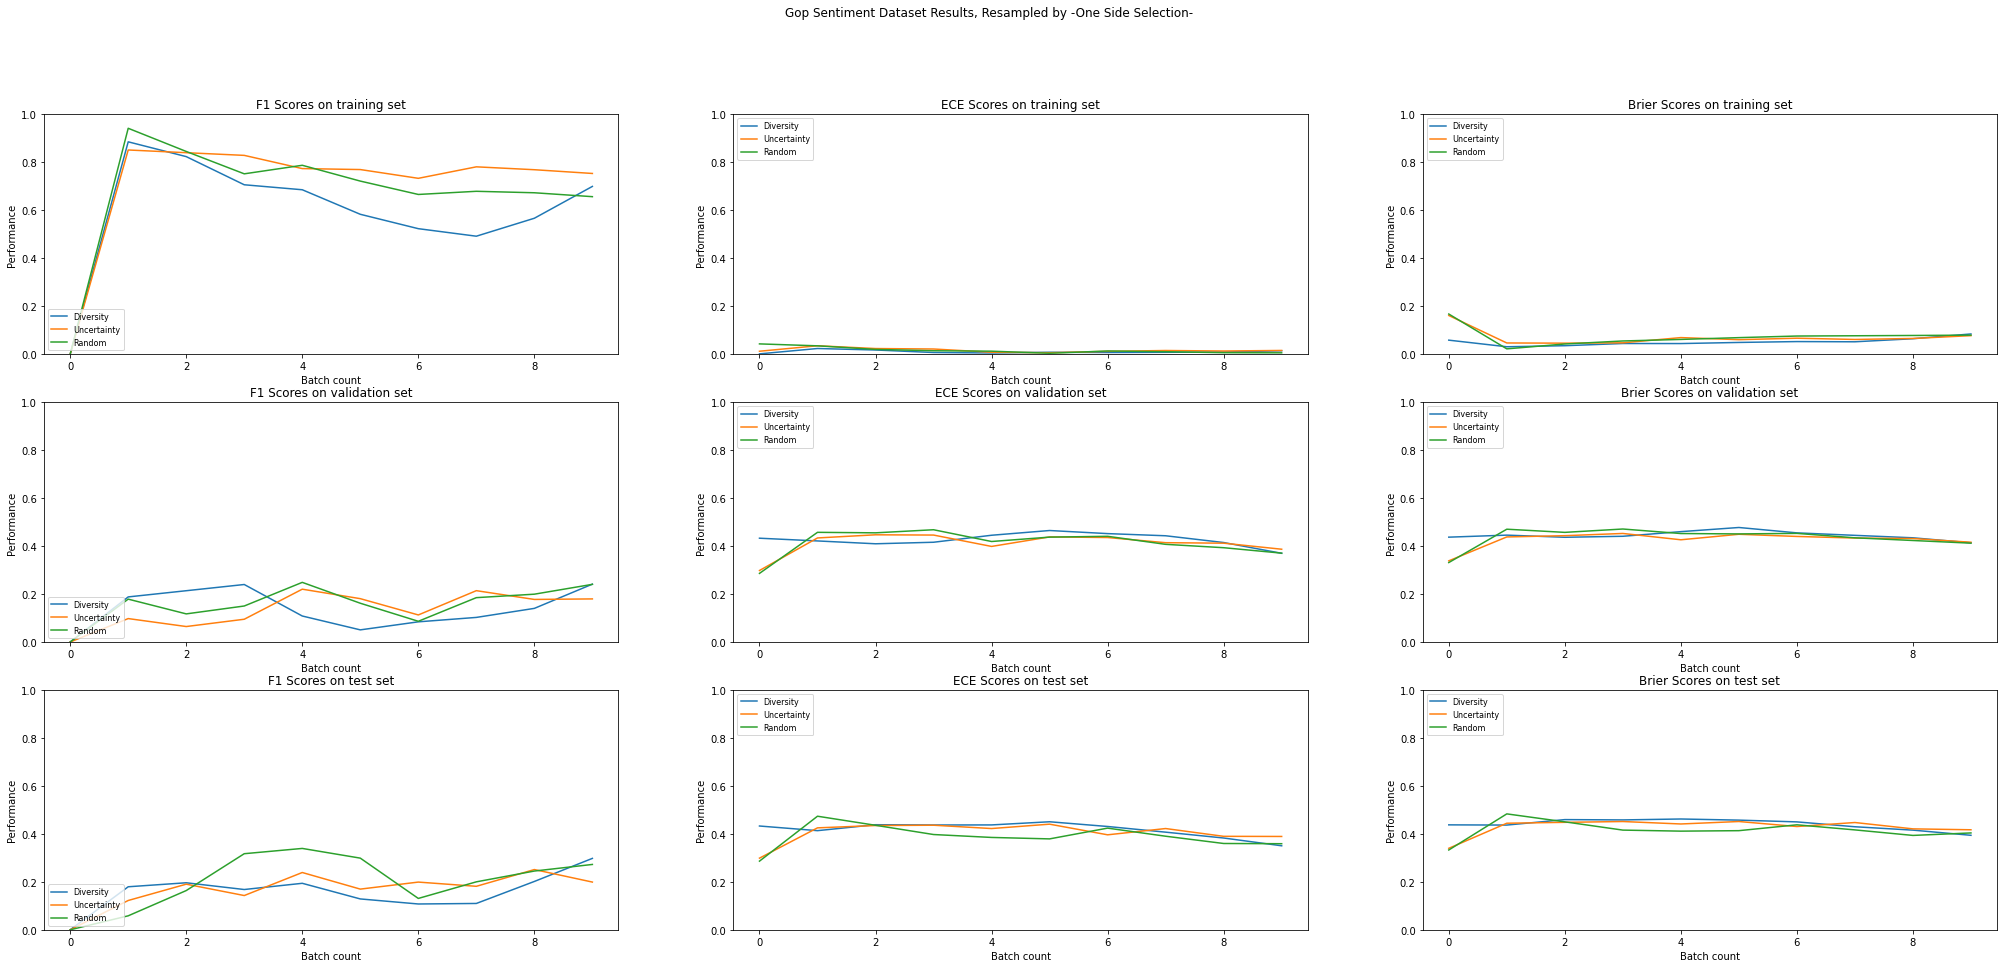

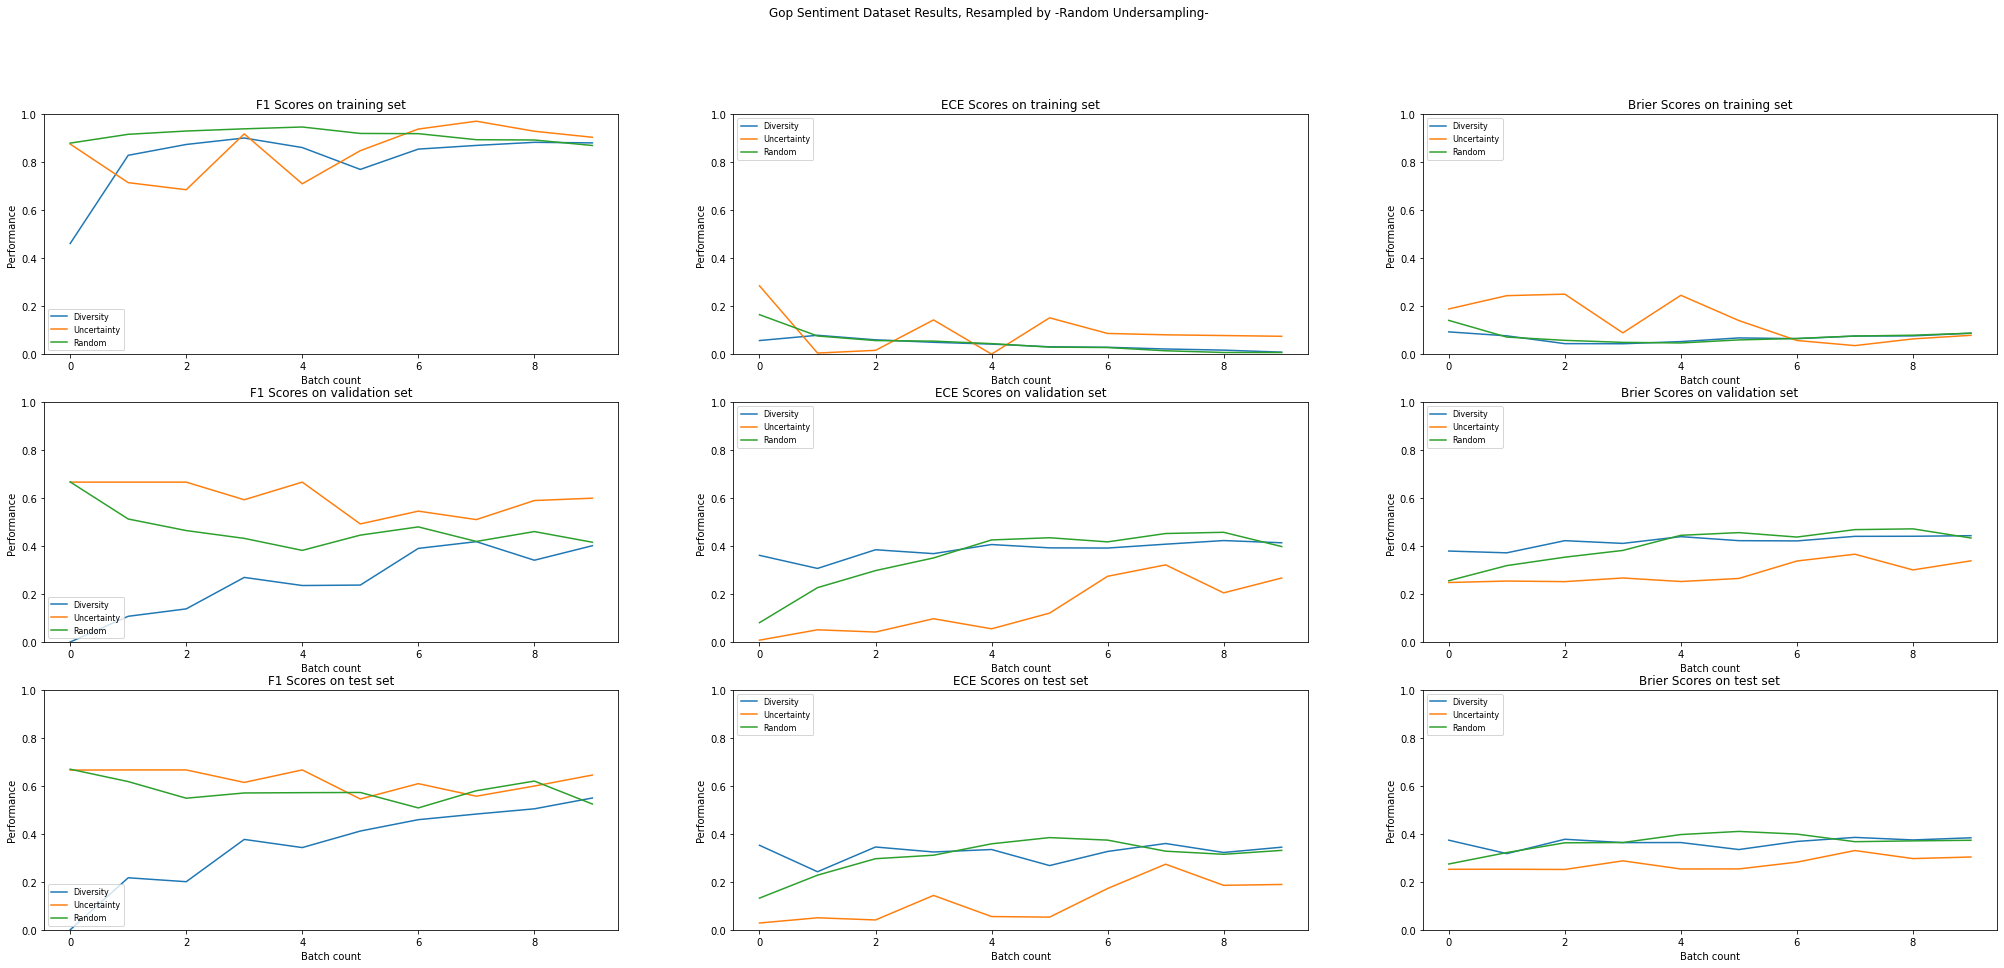

In [20]:
#  [[X, YSet, xLabel, yLabel, labels, 'training'], [], []]
trainD = [diversity_res_oneSideSelection['alBatch'], [[diversity_res_oneSideSelection[" f1_train"].tolist(), diversity_res_oneSideSelection[" ece_train"].tolist(), diversity_res_oneSideSelection[" brier_train"].tolist()], [uncertainty_res_oneSideSelection[" f1_train"].tolist(), uncertainty_res_oneSideSelection[" ece_train"].tolist(), uncertainty_res_oneSideSelection[" brier_train"].tolist()], [random_res_oneSideSelection[" f1_train"].tolist(), random_res_oneSideSelection[" ece_train"].tolist(), random_res_oneSideSelection[" brier_train"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'training']
valD = [diversity_res_oneSideSelection['alBatch'], [[diversity_res_oneSideSelection[" f1_val"].tolist(), diversity_res_oneSideSelection[" ece_val"].tolist(), diversity_res_oneSideSelection[" brier_val"].tolist()], [uncertainty_res_oneSideSelection[" f1_val"].tolist(), uncertainty_res_oneSideSelection[" ece_val"].tolist(), uncertainty_res_oneSideSelection[" brier_val"].tolist()], [random_res_oneSideSelection[" f1_val"].tolist(), random_res_oneSideSelection[" ece_val"].tolist(), random_res_oneSideSelection[" brier_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'validation']
testD = [diversity_res_oneSideSelection['alBatch'], [[diversity_res_oneSideSelection[" f1_test"].tolist(), diversity_res_oneSideSelection[" ece_test"].tolist(), diversity_res_oneSideSelection[" brier_test"].tolist()], [uncertainty_res_oneSideSelection[" f1_test"].tolist(), uncertainty_res_oneSideSelection[" ece_test"].tolist(), uncertainty_res_oneSideSelection[" brier_test"].tolist()], [random_res_oneSideSelection[" f1_test"].tolist(), random_res_oneSideSelection[" ece_test"].tolist(), random_res_oneSideSelection[" brier_test"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'test']

plot_performance([trainD, valD, testD], 'Gop Sentiment Dataset Results, Resampled by -One Side Selection-', 'lower left')

trainD_R = [diversity_res_randomUndersampling['alBatch'], [[diversity_res_randomUndersampling[" f1_train"].tolist(), diversity_res_randomUndersampling[" ece_train"].tolist(), diversity_res_randomUndersampling[" brier_train"].tolist()], [uncertainty_res_randomUndersampling[" f1_train"].tolist(), uncertainty_res_randomUndersampling[" ece_train"].tolist(), uncertainty_res_randomUndersampling[" brier_train"].tolist()], [random_res_randomUndersampling[" f1_train"].tolist(), random_res_randomUndersampling[" ece_train"].tolist(), random_res_randomUndersampling[" brier_train"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'training']
valD_R = [diversity_res_randomUndersampling['alBatch'], [[diversity_res_randomUndersampling[" f1_val"].tolist(), diversity_res_randomUndersampling[" ece_val"].tolist(), diversity_res_randomUndersampling[" brier_val"].tolist()], [uncertainty_res_randomUndersampling[" f1_val"].tolist(), uncertainty_res_randomUndersampling[" ece_val"].tolist(), uncertainty_res_randomUndersampling[" brier_val"].tolist()], [random_res_randomUndersampling[" f1_val"].tolist(), random_res_randomUndersampling[" ece_val"].tolist(), random_res_randomUndersampling[" brier_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'validation']
testD_R = [diversity_res_randomUndersampling['alBatch'], [[diversity_res_randomUndersampling[" f1_test"].tolist(), diversity_res_randomUndersampling[" ece_test"].tolist(), diversity_res_randomUndersampling[" brier_test"].tolist()], [uncertainty_res_randomUndersampling[" f1_test"].tolist(), uncertainty_res_randomUndersampling[" ece_test"].tolist(), uncertainty_res_randomUndersampling[" brier_test"].tolist()], [random_res_randomUndersampling[" f1_test"].tolist(), random_res_randomUndersampling[" ece_test"].tolist(), random_res_randomUndersampling[" brier_test"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'test']

plot_performance([trainD_R, valD_R, testD_R], 'Gop Sentiment Dataset Results, Resampled by -Random Undersampling-', 'lower left')

# ***Disaster Relevance Dataset***

In [21]:
#read data and results

res_path = 'drive/My Drive/Colab Notebooks/deepALForCalibration/res/'
data_folder = 'drive/My Drive/Colab Notebooks/deepALForCalibration/datasets/binary/disaster_relevance/'

oneSideSelectionData = data_folder + '2_train_indexed_disaster_relevance_binary_resampledByOneSideSelection.csv'
random_oneSideSelection = res_path + 'random_2-disaster_relevance-MLP3_resampledByOneSideSelection.csv'
uncertainty_oneSideSelection = res_path + 'uncertainty_2-disaster_relevance-MLP3_resampledByOneSideSelection.csv'
diversity_oneSideSelection = res_path + 'diversity_2-disaster_relevance-MLP3_resampledByOneSideSelection.csv'

randomUndersamplingData = data_folder + '2_train_indexed_disaster_relevance_binary_resampledByRandomUndersampling.csv'
random_undersampling = res_path + 'random_2-disaster_relevance-MLP3_resampledByRandomUndersampling.csv'
uncertainty_undersampling = res_path + 'uncertainty_2-disaster_relevance-MLP3_resampledByRandomUndersampling.csv'
diversity_undersampling = res_path + 'diversity_2-disaster_relevance-MLP3_resampledByRandomUndersampling.csv'

data_oneSideSelection = pd.read_csv(oneSideSelectionData)
random_res_oneSideSelection = pd.read_csv(random_oneSideSelection)
uncertainty_res_oneSideSelection = pd.read_csv(uncertainty_oneSideSelection)
diversity_res_oneSideSelection = pd.read_csv(diversity_oneSideSelection)

data_randomUndersampling = pd.read_csv(randomUndersamplingData)
random_res_randomUndersampling = pd.read_csv(random_undersampling)
uncertainty_res_randomUndersampling = pd.read_csv(uncertainty_undersampling)
diversity_res_randomUndersampling = pd.read_csv(diversity_undersampling)

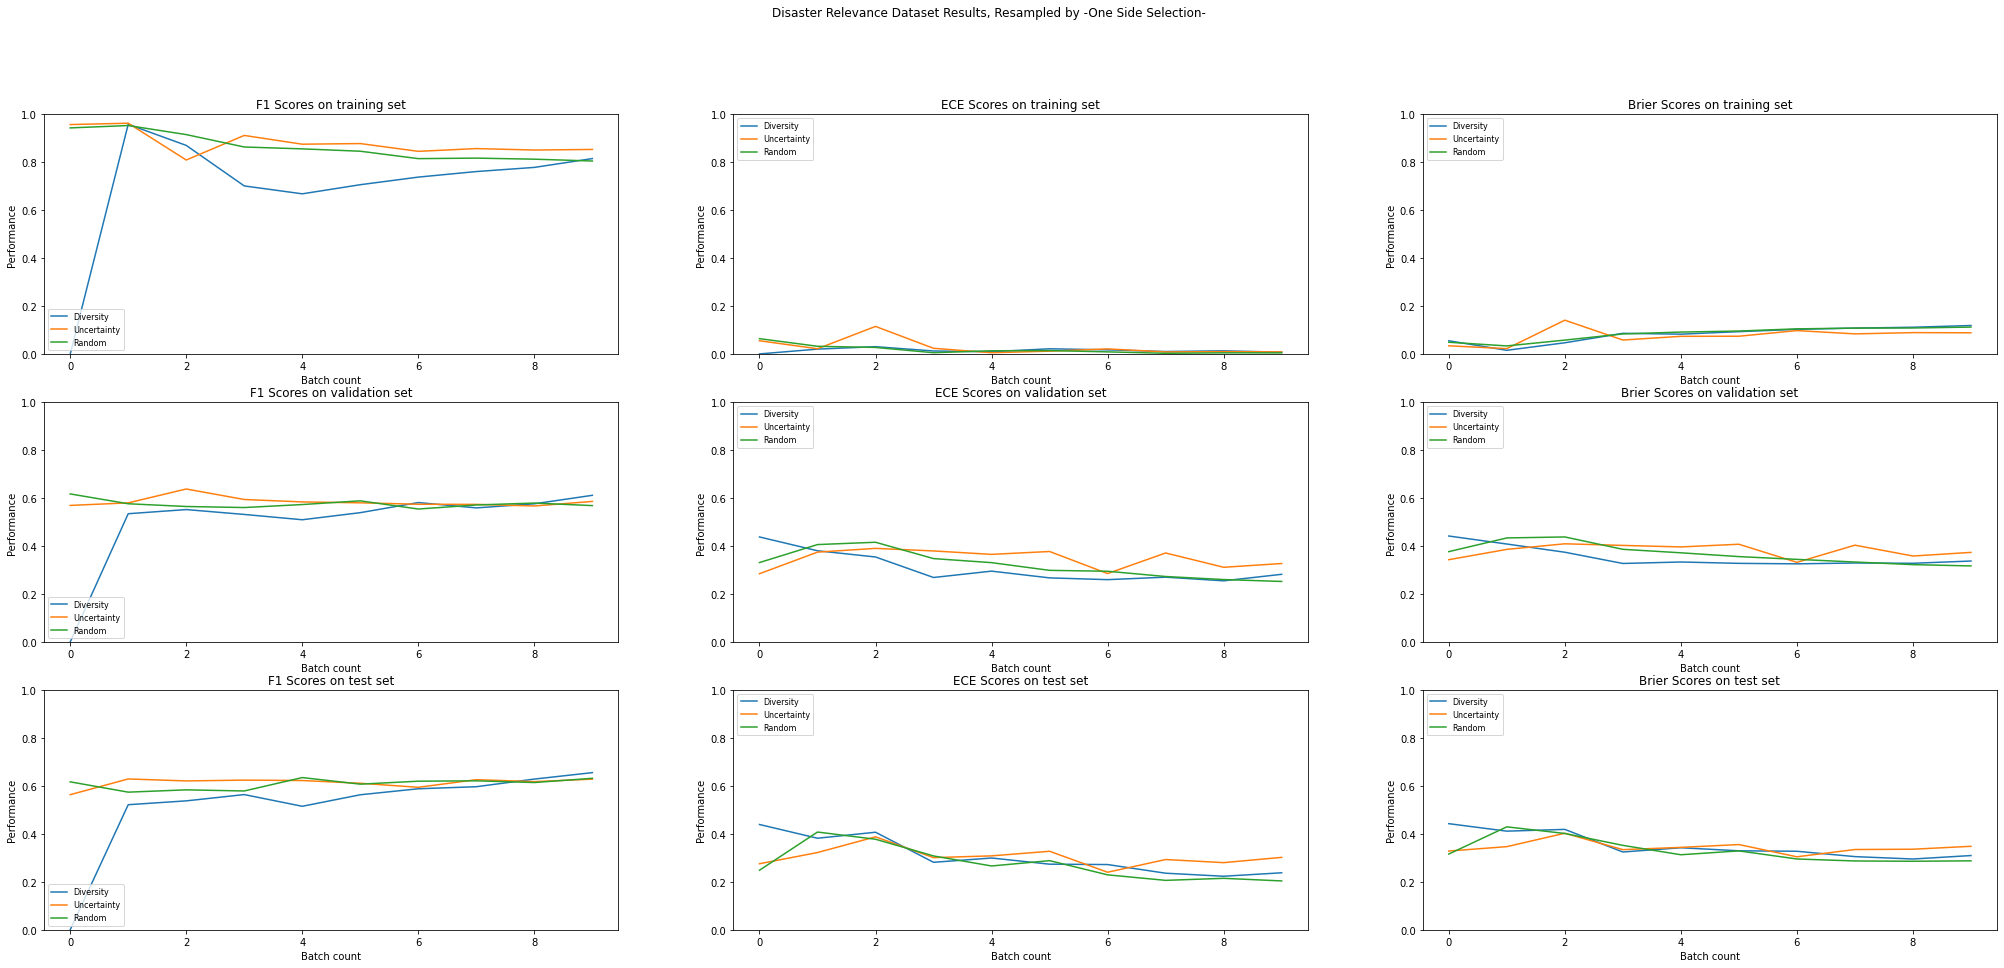

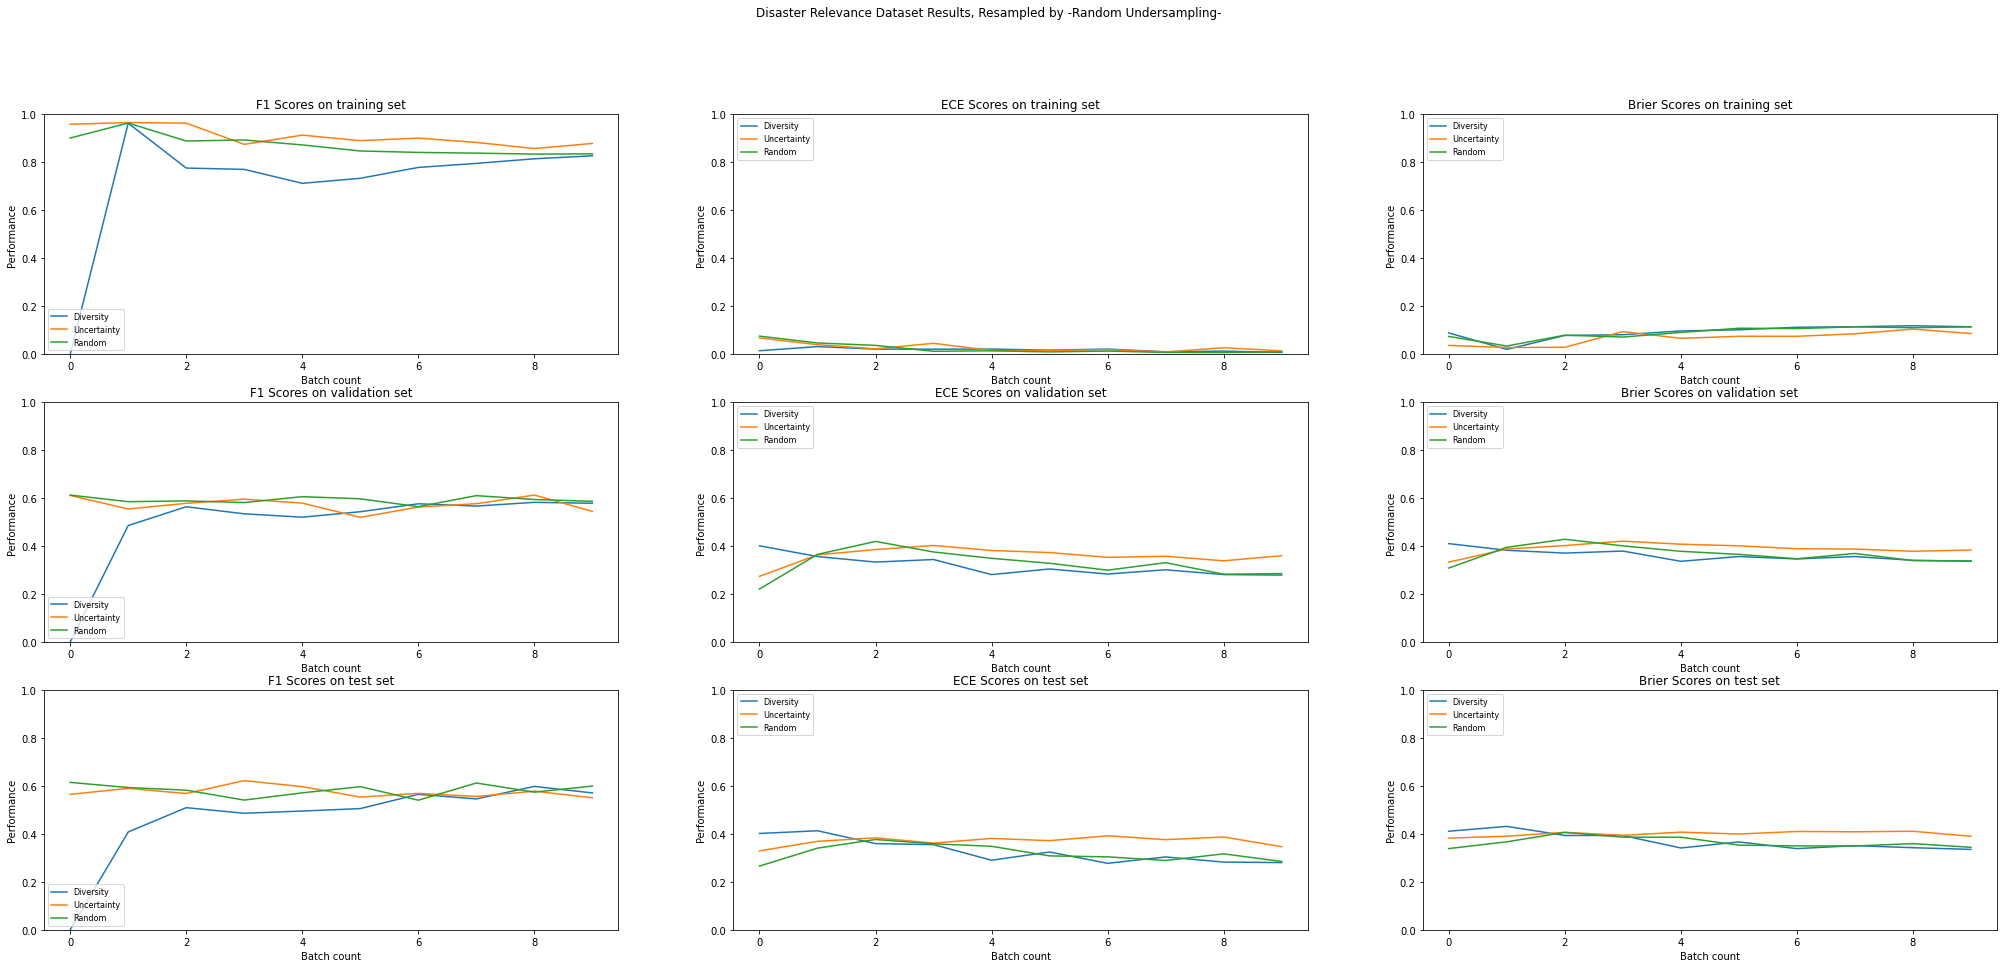

In [22]:
trainD = [diversity_res_oneSideSelection['alBatch'], [[diversity_res_oneSideSelection[" f1_train"].tolist(), diversity_res_oneSideSelection[" ece_train"].tolist(), diversity_res_oneSideSelection[" brier_train"].tolist()], [uncertainty_res_oneSideSelection[" f1_train"].tolist(), uncertainty_res_oneSideSelection[" ece_train"].tolist(), uncertainty_res_oneSideSelection[" brier_train"].tolist()], [random_res_oneSideSelection[" f1_train"].tolist(), random_res_oneSideSelection[" ece_train"].tolist(), random_res_oneSideSelection[" brier_train"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'training']
valD = [diversity_res_oneSideSelection['alBatch'], [[diversity_res_oneSideSelection[" f1_val"].tolist(), diversity_res_oneSideSelection[" ece_val"].tolist(), diversity_res_oneSideSelection[" brier_val"].tolist()], [uncertainty_res_oneSideSelection[" f1_val"].tolist(), uncertainty_res_oneSideSelection[" ece_val"].tolist(), uncertainty_res_oneSideSelection[" brier_val"].tolist()], [random_res_oneSideSelection[" f1_val"].tolist(), random_res_oneSideSelection[" ece_val"].tolist(), random_res_oneSideSelection[" brier_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'validation']
testD = [diversity_res_oneSideSelection['alBatch'], [[diversity_res_oneSideSelection[" f1_test"].tolist(), diversity_res_oneSideSelection[" ece_test"].tolist(), diversity_res_oneSideSelection[" brier_test"].tolist()], [uncertainty_res_oneSideSelection[" f1_test"].tolist(), uncertainty_res_oneSideSelection[" ece_test"].tolist(), uncertainty_res_oneSideSelection[" brier_test"].tolist()], [random_res_oneSideSelection[" f1_test"].tolist(), random_res_oneSideSelection[" ece_test"].tolist(), random_res_oneSideSelection[" brier_test"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'test']

plot_performance([trainD, valD, testD], 'Disaster Relevance Dataset Results, Resampled by -One Side Selection-', 'lower left')

trainD_R = [diversity_res_randomUndersampling['alBatch'], [[diversity_res_randomUndersampling[" f1_train"].tolist(), diversity_res_randomUndersampling[" ece_train"].tolist(), diversity_res_randomUndersampling[" brier_train"].tolist()], [uncertainty_res_randomUndersampling[" f1_train"].tolist(), uncertainty_res_randomUndersampling[" ece_train"].tolist(), uncertainty_res_randomUndersampling[" brier_train"].tolist()], [random_res_randomUndersampling[" f1_train"].tolist(), random_res_randomUndersampling[" ece_train"].tolist(), random_res_randomUndersampling[" brier_train"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'training']
valD_R = [diversity_res_randomUndersampling['alBatch'], [[diversity_res_randomUndersampling[" f1_val"].tolist(), diversity_res_randomUndersampling[" ece_val"].tolist(), diversity_res_randomUndersampling[" brier_val"].tolist()], [uncertainty_res_randomUndersampling[" f1_val"].tolist(), uncertainty_res_randomUndersampling[" ece_val"].tolist(), uncertainty_res_randomUndersampling[" brier_val"].tolist()], [random_res_randomUndersampling[" f1_val"].tolist(), random_res_randomUndersampling[" ece_val"].tolist(), random_res_randomUndersampling[" brier_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'validation']
testD_R = [diversity_res_randomUndersampling['alBatch'], [[diversity_res_randomUndersampling[" f1_test"].tolist(), diversity_res_randomUndersampling[" ece_test"].tolist(), diversity_res_randomUndersampling[" brier_test"].tolist()], [uncertainty_res_randomUndersampling[" f1_test"].tolist(), uncertainty_res_randomUndersampling[" ece_test"].tolist(), uncertainty_res_randomUndersampling[" brier_test"].tolist()], [random_res_randomUndersampling[" f1_test"].tolist(), random_res_randomUndersampling[" ece_test"].tolist(), random_res_randomUndersampling[" brier_test"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'test']

plot_performance([trainD_R, valD_R, testD_R], 'Disaster Relevance Dataset Results, Resampled by -Random Undersampling-', 'lower left')

# ***Chems Contributing to Disease Dataset***

Contributors read sentences in which both a chemical (like Aspirin) and a disease (or side-effect) were present. They then determined if the chemical directly contributed to the disease or caused it. Dataset includes chemical names, disease name, and aggregated judgments of five (as opposed to the usual three) contributors. 

Source: https://www.crowdflower.com/data-for-everyone/

In [23]:
#read data and results

res_path = 'drive/My Drive/Colab Notebooks/deepALForCalibration/res/'
data_folder = 'drive/My Drive/Colab Notebooks/deepALForCalibration/datasets/binary/chemicals_disease/'

oneSideSelectionData = data_folder + '3_train_indexed_chemicals_disease_binary_resampledByOneSideSelection.csv'
random_oneSideSelection = res_path + 'random_3-chemicals_disease-MLP3_resampledByOneSideSelection.csv'
uncertainty_oneSideSelection = res_path + 'uncertainty_3-chemicals_disease-MLP3_resampledByOneSideSelection.csv'
diversity_oneSideSelection = res_path + 'diversity_3-chemicals_disease-MLP3_resampledByOneSideSelection.csv'

randomUndersamplingData = data_folder + '3_train_indexed_chemicals_disease_binary_resampledByRandomUndersampling.csv'
random_undersampling = res_path + 'random_3-chemicals_disease-MLP3_resampledByRandomUndersampling.csv'
uncertainty_undersampling = res_path + 'uncertainty_3-chemicals_disease-MLP3_resampledByRandomUndersampling.csv'
diversity_undersampling = res_path + 'diversity_3-chemicals_disease-MLP3_resampledByRandomUndersampling.csv'

data_oneSideSelection = pd.read_csv(oneSideSelectionData)
random_res_oneSideSelection = pd.read_csv(random_oneSideSelection)
uncertainty_res_oneSideSelection = pd.read_csv(uncertainty_oneSideSelection)
diversity_res_oneSideSelection = pd.read_csv(diversity_oneSideSelection)

data_randomUndersampling = pd.read_csv(randomUndersamplingData)
random_res_randomUndersampling = pd.read_csv(random_undersampling)
uncertainty_res_randomUndersampling = pd.read_csv(uncertainty_undersampling)
diversity_res_randomUndersampling = pd.read_csv(diversity_undersampling)

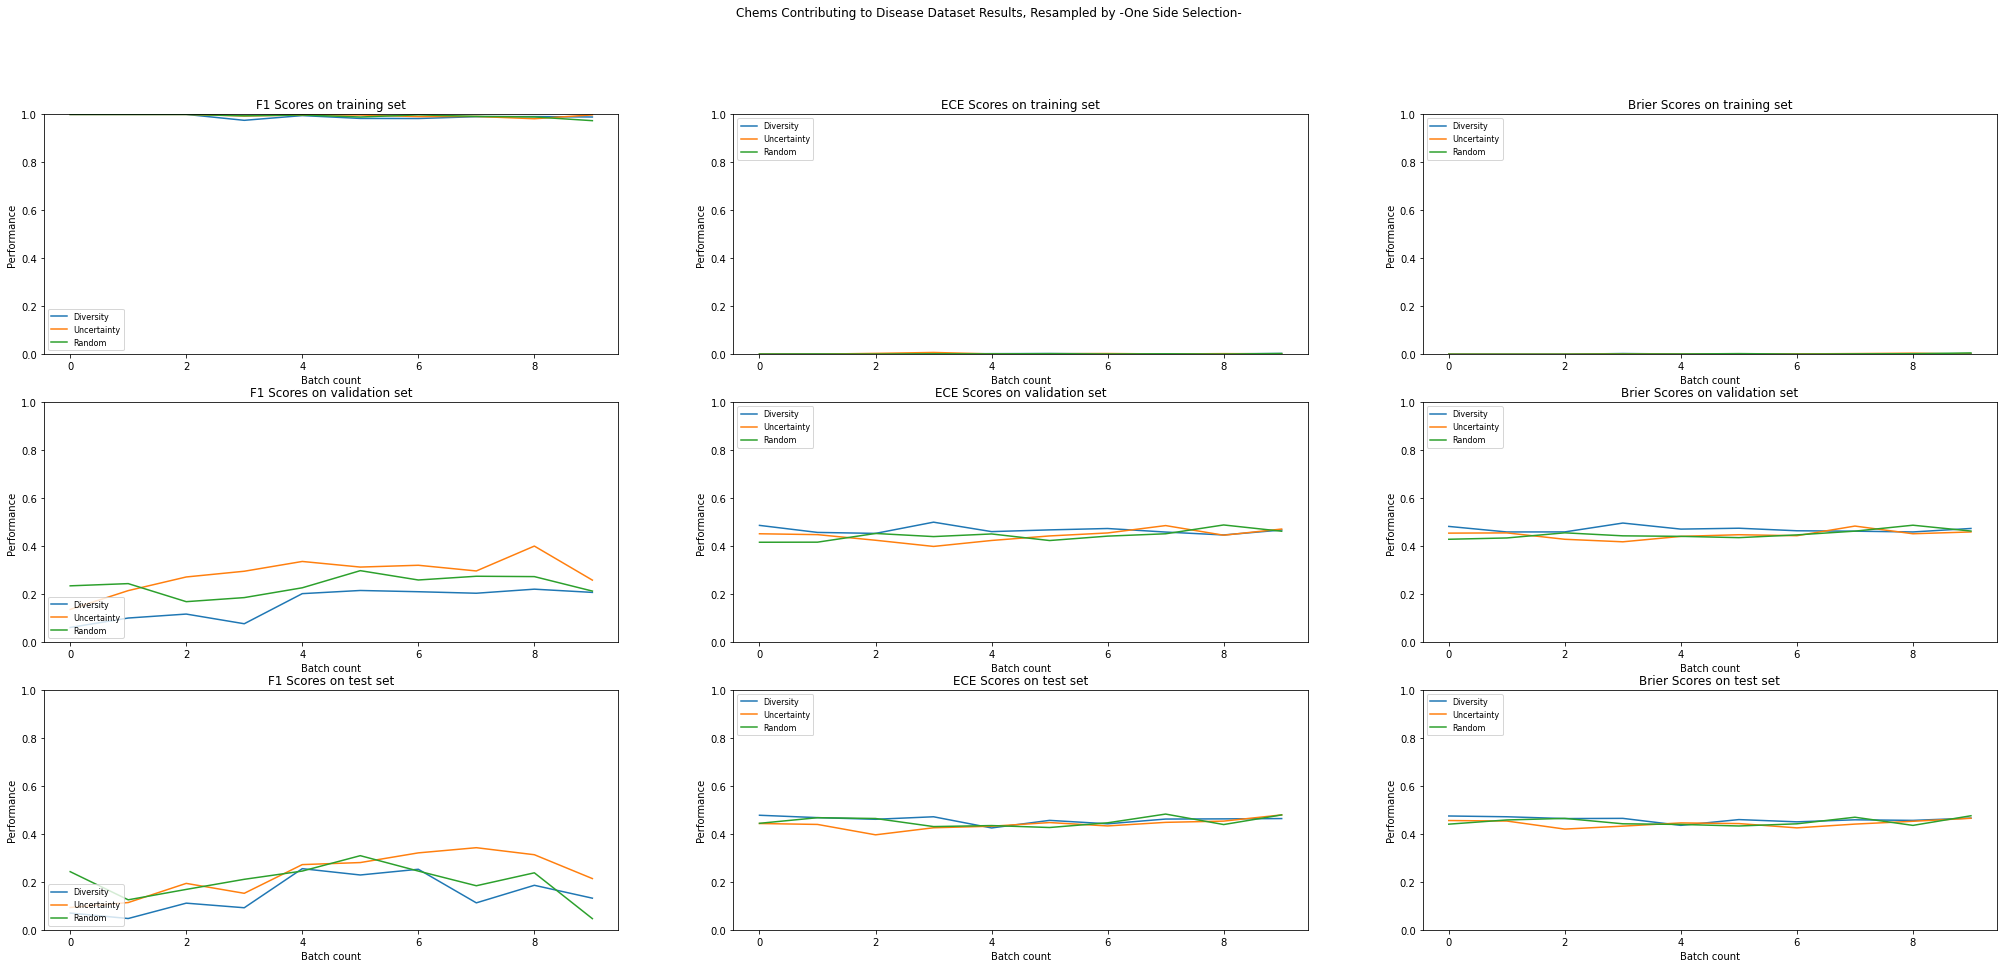

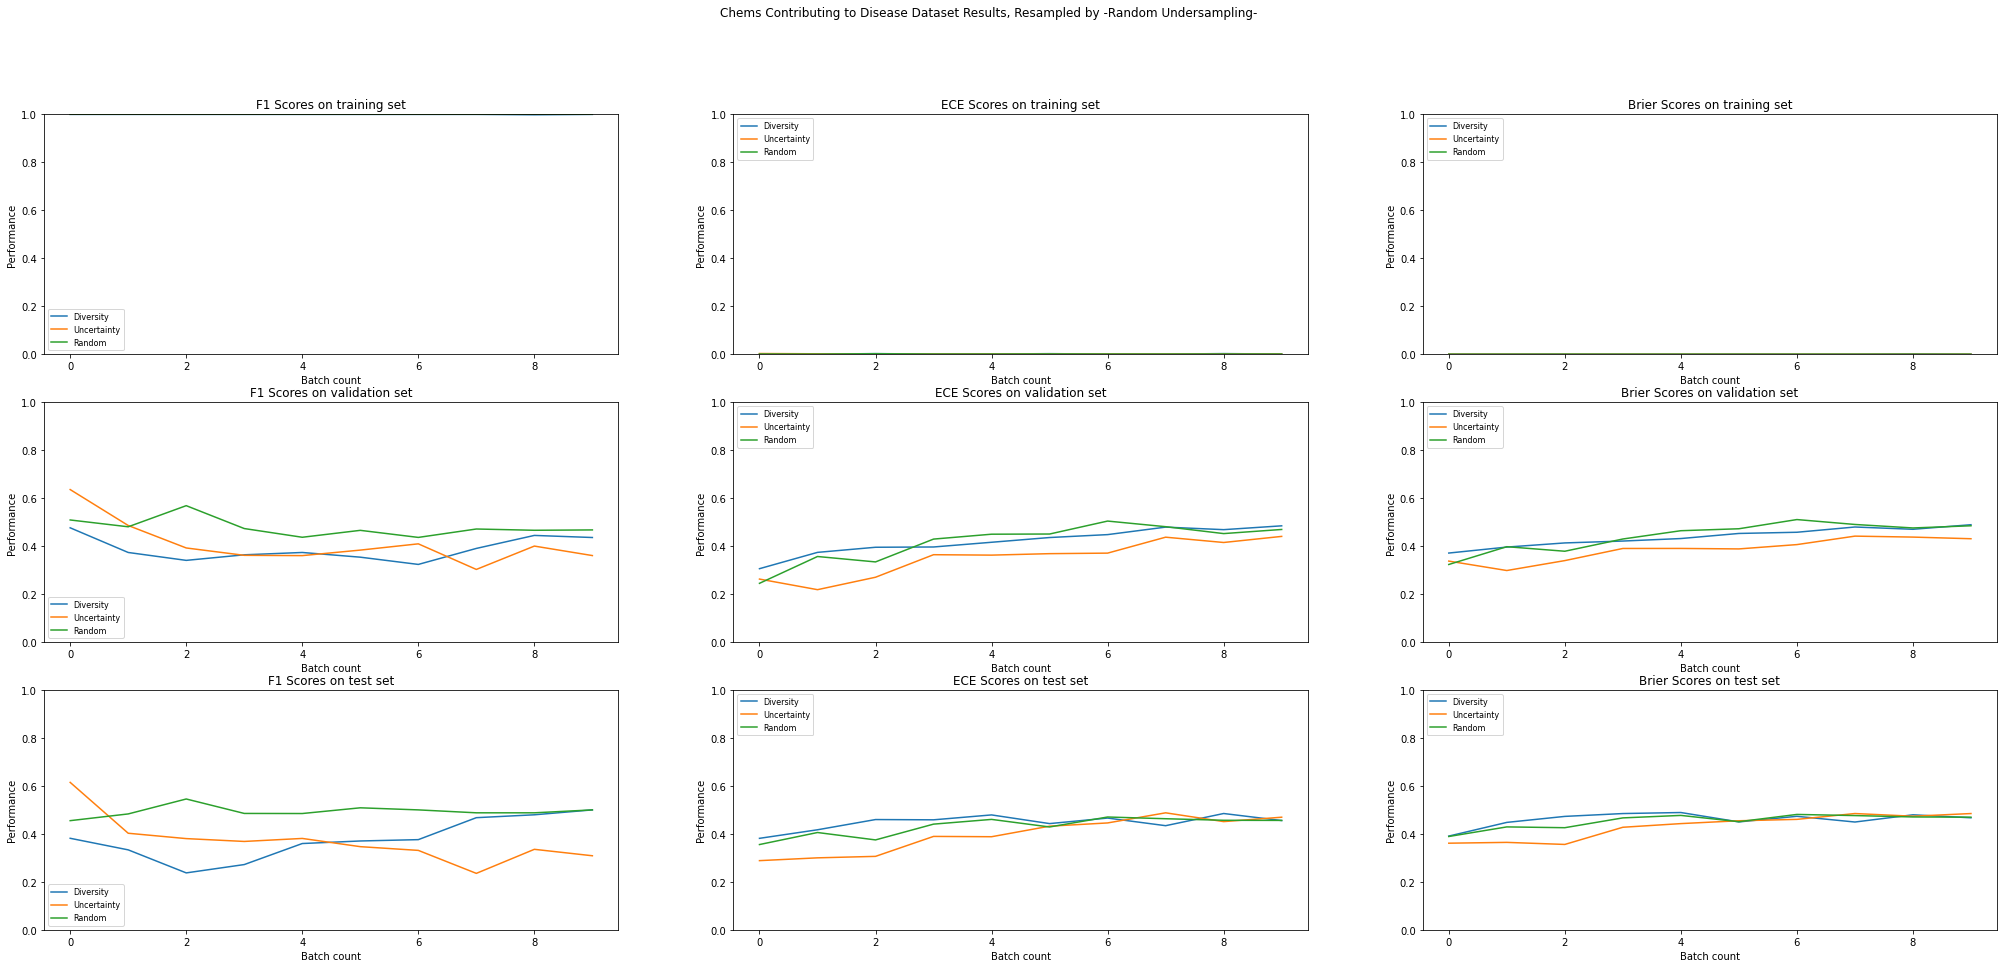

In [24]:
trainD = [diversity_res_oneSideSelection['alBatch'], [[diversity_res_oneSideSelection[" f1_train"].tolist(), diversity_res_oneSideSelection[" ece_train"].tolist(), diversity_res_oneSideSelection[" brier_train"].tolist()], [uncertainty_res_oneSideSelection[" f1_train"].tolist(), uncertainty_res_oneSideSelection[" ece_train"].tolist(), uncertainty_res_oneSideSelection[" brier_train"].tolist()], [random_res_oneSideSelection[" f1_train"].tolist(), random_res_oneSideSelection[" ece_train"].tolist(), random_res_oneSideSelection[" brier_train"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'training']
valD = [diversity_res_oneSideSelection['alBatch'], [[diversity_res_oneSideSelection[" f1_val"].tolist(), diversity_res_oneSideSelection[" ece_val"].tolist(), diversity_res_oneSideSelection[" brier_val"].tolist()], [uncertainty_res_oneSideSelection[" f1_val"].tolist(), uncertainty_res_oneSideSelection[" ece_val"].tolist(), uncertainty_res_oneSideSelection[" brier_val"].tolist()], [random_res_oneSideSelection[" f1_val"].tolist(), random_res_oneSideSelection[" ece_val"].tolist(), random_res_oneSideSelection[" brier_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'validation']
testD = [diversity_res_oneSideSelection['alBatch'], [[diversity_res_oneSideSelection[" f1_test"].tolist(), diversity_res_oneSideSelection[" ece_test"].tolist(), diversity_res_oneSideSelection[" brier_test"].tolist()], [uncertainty_res_oneSideSelection[" f1_test"].tolist(), uncertainty_res_oneSideSelection[" ece_test"].tolist(), uncertainty_res_oneSideSelection[" brier_test"].tolist()], [random_res_oneSideSelection[" f1_test"].tolist(), random_res_oneSideSelection[" ece_test"].tolist(), random_res_oneSideSelection[" brier_test"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'test']

plot_performance([trainD, valD, testD], 'Chems Contributing to Disease Dataset Results, Resampled by -One Side Selection-', 'lower left')

trainD_R = [diversity_res_randomUndersampling['alBatch'], [[diversity_res_randomUndersampling[" f1_train"].tolist(), diversity_res_randomUndersampling[" ece_train"].tolist(), diversity_res_randomUndersampling[" brier_train"].tolist()], [uncertainty_res_randomUndersampling[" f1_train"].tolist(), uncertainty_res_randomUndersampling[" ece_train"].tolist(), uncertainty_res_randomUndersampling[" brier_train"].tolist()], [random_res_randomUndersampling[" f1_train"].tolist(), random_res_randomUndersampling[" ece_train"].tolist(), random_res_randomUndersampling[" brier_train"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'training']
valD_R = [diversity_res_randomUndersampling['alBatch'], [[diversity_res_randomUndersampling[" f1_val"].tolist(), diversity_res_randomUndersampling[" ece_val"].tolist(), diversity_res_randomUndersampling[" brier_val"].tolist()], [uncertainty_res_randomUndersampling[" f1_val"].tolist(), uncertainty_res_randomUndersampling[" ece_val"].tolist(), uncertainty_res_randomUndersampling[" brier_val"].tolist()], [random_res_randomUndersampling[" f1_val"].tolist(), random_res_randomUndersampling[" ece_val"].tolist(), random_res_randomUndersampling[" brier_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'validation']
testD_R = [diversity_res_randomUndersampling['alBatch'], [[diversity_res_randomUndersampling[" f1_test"].tolist(), diversity_res_randomUndersampling[" ece_test"].tolist(), diversity_res_randomUndersampling[" brier_test"].tolist()], [uncertainty_res_randomUndersampling[" f1_test"].tolist(), uncertainty_res_randomUndersampling[" ece_test"].tolist(), uncertainty_res_randomUndersampling[" brier_test"].tolist()], [random_res_randomUndersampling[" f1_test"].tolist(), random_res_randomUndersampling[" ece_test"].tolist(), random_res_randomUndersampling[" brier_test"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'test']

plot_performance([trainD_R, valD_R, testD_R], 'Chems Contributing to Disease Dataset Results, Resampled by -Random Undersampling-', 'lower left')

# ***Economic News Dataset***
Contributors read snippets of news articles. They then noted if the article was relevant to the US economy and, if so, what the tone of the article was. Tone was judged on a 9 point scale (from 1 to 9, with 1 representing the most negativity). Dataset contains these judgments as well as the dates, source titles, and text. Dates range from 1951 to 2014. 

Source: https://www.crowdflower.com/data-for-everyone/


In [25]:
#read data and results

res_path = 'drive/My Drive/Colab Notebooks/deepALForCalibration/res/'
data_folder = 'drive/My Drive/Colab Notebooks/deepALForCalibration/datasets/binary/economic_news/'

oneSideSelectionData = data_folder + '4_train_indexed_economic_news_binary_resampledByOneSideSelection.csv'
random_oneSideSelection = res_path + 'random_4-economic_news-MLP3_resampledByOneSideSelection.csv'
uncertainty_oneSideSelection = res_path + 'uncertainty_4-economic_news-MLP3_resampledByOneSideSelection.csv'
diversity_oneSideSelection = res_path + 'diversity_4-economic_news-MLP3_resampledByOneSideSelection.csv'

randomUndersamplingData = data_folder + '4_train_indexed_economic_news_binary_resampledByRandomUndersampling.csv'
random_undersampling = res_path + 'random_4-economic_news-MLP3_resampledByRandomUndersampling.csv'
uncertainty_undersampling = res_path + 'uncertainty_4-economic_news-MLP3_resampledByRandomUndersampling.csv'
diversity_undersampling = res_path + 'diversity_4-economic_news-MLP3_resampledByRandomUndersampling.csv'

data_oneSideSelection = pd.read_csv(oneSideSelectionData)
random_res_oneSideSelection = pd.read_csv(random_oneSideSelection)
uncertainty_res_oneSideSelection = pd.read_csv(uncertainty_oneSideSelection)
diversity_res_oneSideSelection = pd.read_csv(diversity_oneSideSelection)

data_randomUndersampling = pd.read_csv(randomUndersamplingData)
random_res_randomUndersampling = pd.read_csv(random_undersampling)
uncertainty_res_randomUndersampling = pd.read_csv(uncertainty_undersampling)
diversity_res_randomUndersampling = pd.read_csv(diversity_undersampling)

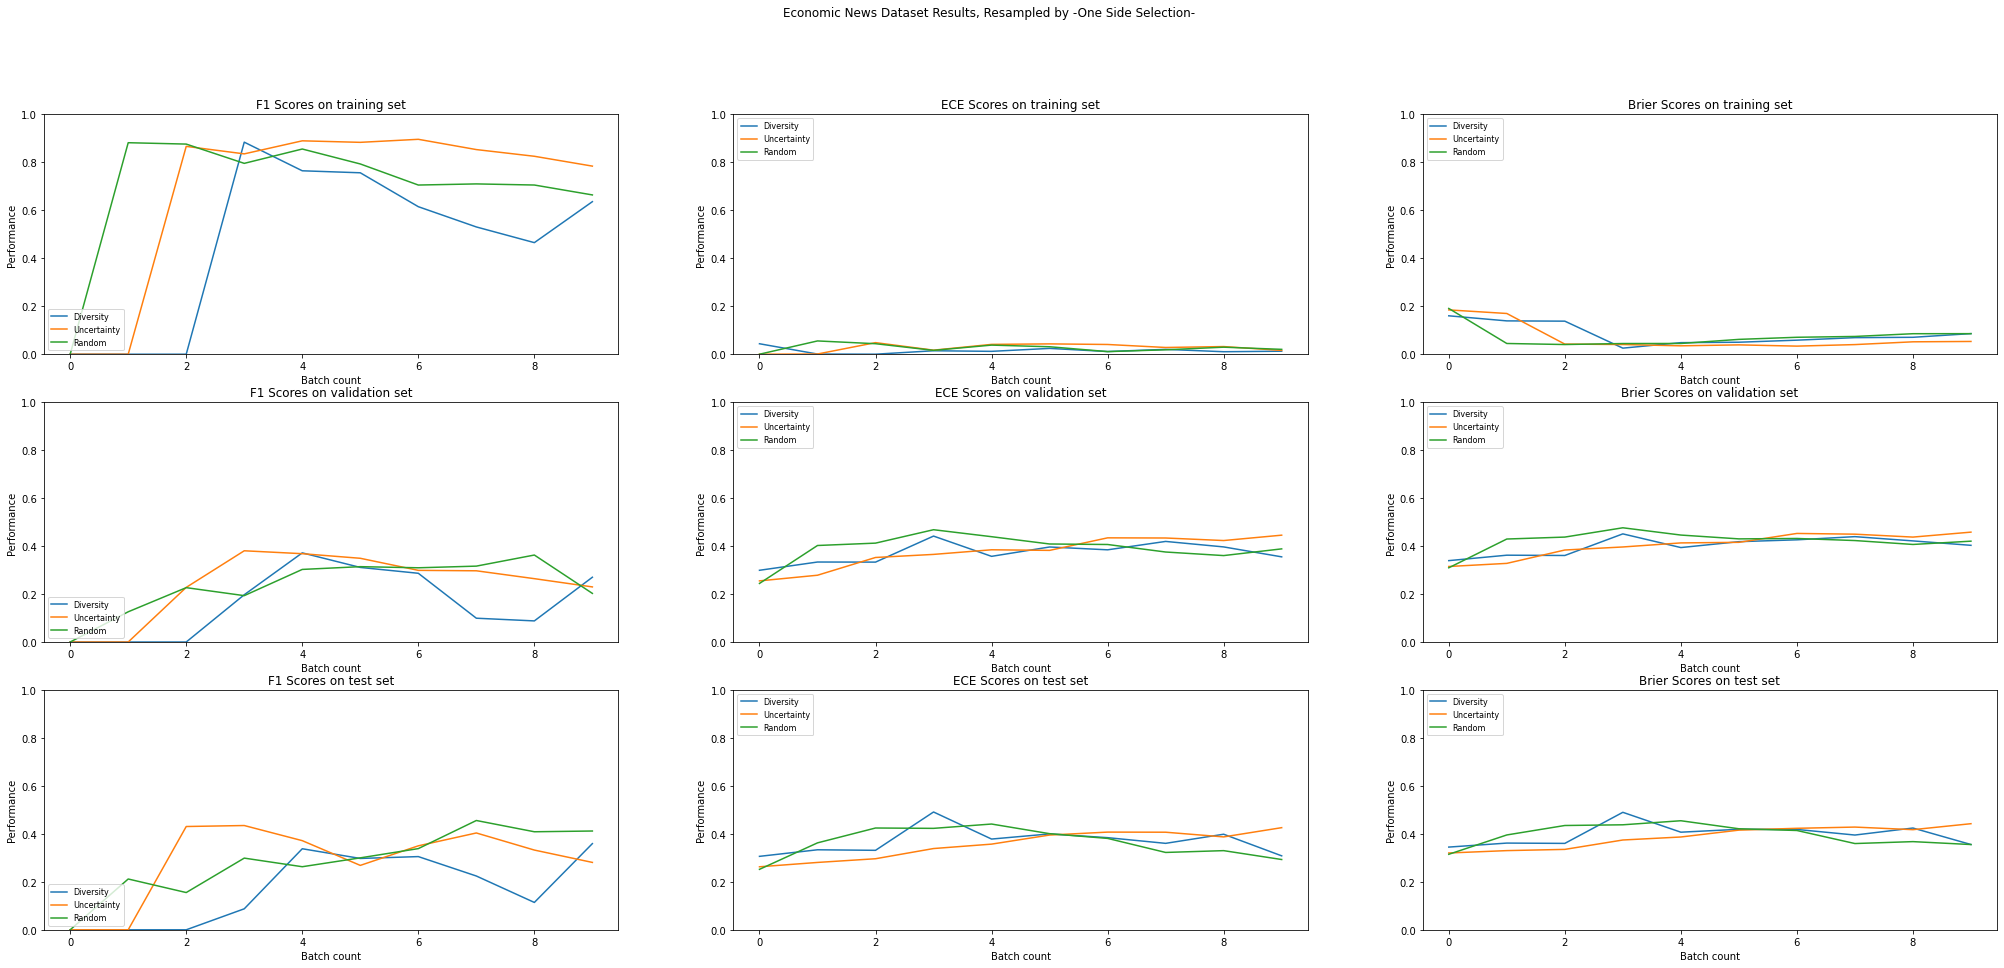

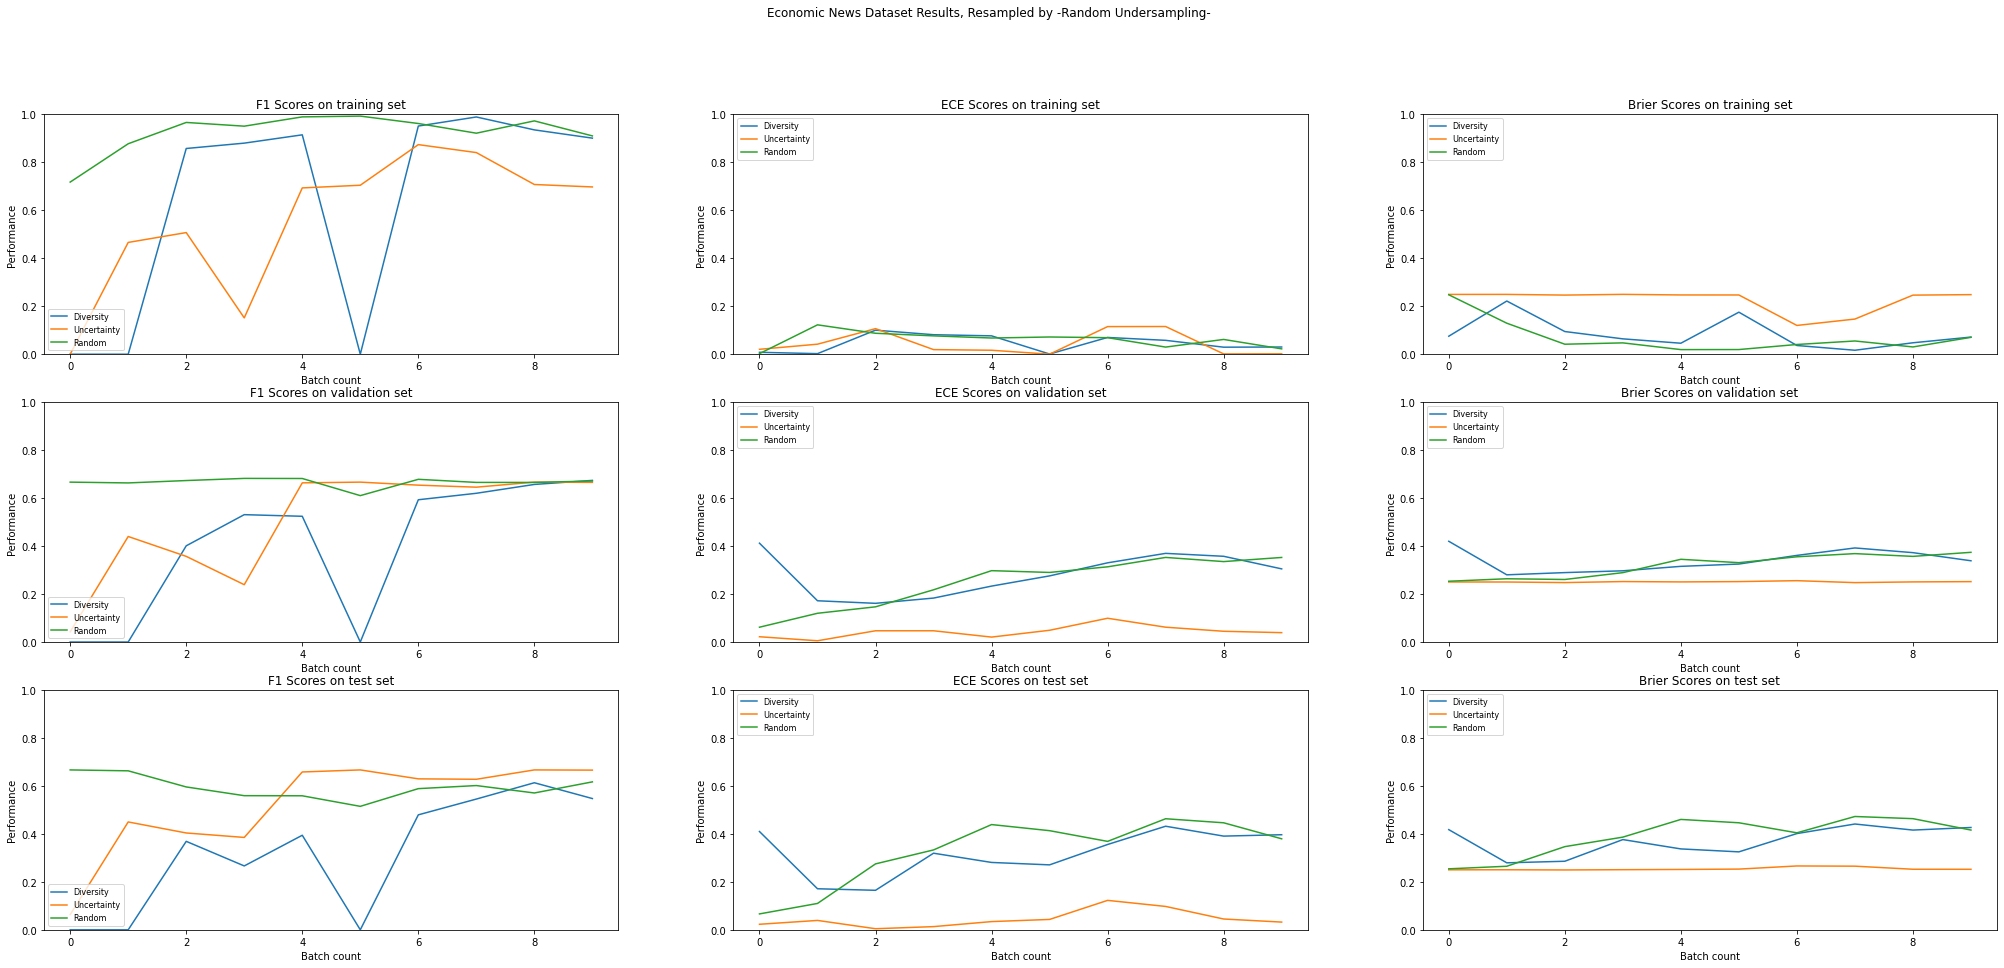

In [26]:
trainD = [diversity_res_oneSideSelection['alBatch'], [[diversity_res_oneSideSelection[" f1_train"].tolist(), diversity_res_oneSideSelection[" ece_train"].tolist(), diversity_res_oneSideSelection[" brier_train"].tolist()], [uncertainty_res_oneSideSelection[" f1_train"].tolist(), uncertainty_res_oneSideSelection[" ece_train"].tolist(), uncertainty_res_oneSideSelection[" brier_train"].tolist()], [random_res_oneSideSelection[" f1_train"].tolist(), random_res_oneSideSelection[" ece_train"].tolist(), random_res_oneSideSelection[" brier_train"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'training']
valD = [diversity_res_oneSideSelection['alBatch'], [[diversity_res_oneSideSelection[" f1_val"].tolist(), diversity_res_oneSideSelection[" ece_val"].tolist(), diversity_res_oneSideSelection[" brier_val"].tolist()], [uncertainty_res_oneSideSelection[" f1_val"].tolist(), uncertainty_res_oneSideSelection[" ece_val"].tolist(), uncertainty_res_oneSideSelection[" brier_val"].tolist()], [random_res_oneSideSelection[" f1_val"].tolist(), random_res_oneSideSelection[" ece_val"].tolist(), random_res_oneSideSelection[" brier_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'validation']
testD = [diversity_res_oneSideSelection['alBatch'], [[diversity_res_oneSideSelection[" f1_test"].tolist(), diversity_res_oneSideSelection[" ece_test"].tolist(), diversity_res_oneSideSelection[" brier_test"].tolist()], [uncertainty_res_oneSideSelection[" f1_test"].tolist(), uncertainty_res_oneSideSelection[" ece_test"].tolist(), uncertainty_res_oneSideSelection[" brier_test"].tolist()], [random_res_oneSideSelection[" f1_test"].tolist(), random_res_oneSideSelection[" ece_test"].tolist(), random_res_oneSideSelection[" brier_test"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'test']

plot_performance([trainD, valD, testD], 'Economic News Dataset Results, Resampled by -One Side Selection-', 'lower left')

trainD_R = [diversity_res_randomUndersampling['alBatch'], [[diversity_res_randomUndersampling[" f1_train"].tolist(), diversity_res_randomUndersampling[" ece_train"].tolist(), diversity_res_randomUndersampling[" brier_train"].tolist()], [uncertainty_res_randomUndersampling[" f1_train"].tolist(), uncertainty_res_randomUndersampling[" ece_train"].tolist(), uncertainty_res_randomUndersampling[" brier_train"].tolist()], [random_res_randomUndersampling[" f1_train"].tolist(), random_res_randomUndersampling[" ece_train"].tolist(), random_res_randomUndersampling[" brier_train"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'training']
valD_R = [diversity_res_randomUndersampling['alBatch'], [[diversity_res_randomUndersampling[" f1_val"].tolist(), diversity_res_randomUndersampling[" ece_val"].tolist(), diversity_res_randomUndersampling[" brier_val"].tolist()], [uncertainty_res_randomUndersampling[" f1_val"].tolist(), uncertainty_res_randomUndersampling[" ece_val"].tolist(), uncertainty_res_randomUndersampling[" brier_val"].tolist()], [random_res_randomUndersampling[" f1_val"].tolist(), random_res_randomUndersampling[" ece_val"].tolist(), random_res_randomUndersampling[" brier_val"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'validation']
testD_R = [diversity_res_randomUndersampling['alBatch'], [[diversity_res_randomUndersampling[" f1_test"].tolist(), diversity_res_randomUndersampling[" ece_test"].tolist(), diversity_res_randomUndersampling[" brier_test"].tolist()], [uncertainty_res_randomUndersampling[" f1_test"].tolist(), uncertainty_res_randomUndersampling[" ece_test"].tolist(), uncertainty_res_randomUndersampling[" brier_test"].tolist()], [random_res_randomUndersampling[" f1_test"].tolist(), random_res_randomUndersampling[" ece_test"].tolist(), random_res_randomUndersampling[" brier_test"].tolist()]], 'Batch count', 'Performance', ['Diversity', 'Uncertainty', 'Random'], 'test']

plot_performance([trainD_R, valD_R, testD_R], 'Economic News Dataset Results, Resampled by -Random Undersampling-', 'lower left')